# Teacher's Assignment - Extra Credit #2

***Author:*** *Ofir Paz* $\qquad$ ***Version:*** *17.07.2024* $\qquad$ ***Course:*** *22961 - Deep Learning* \
***Extra Assignment Course:*** *20999 - Extra Assignment 4*

Welcome to the first question of the extra assignment #2 as part of the course *Deep Learning*. \
In this question we will train different types of auto encoders on the MNIST dataset and compare the results with various plots.

## Imports

In [1]:
import torch  # pytorch.
import torch.nn as nn  # neural network module.
import numpy as np  # numpy - scientific calculations.
from torch.utils.data import DataLoader, Dataset  # data handling.
from sklearn.datasets import fetch_openml  # To fetch the hand-written digits dataset.
from sklearn.model_selection import train_test_split  # To split the dataset into training and testing sets.
import matplotlib.pyplot as plt  # plotting module.
from tqdm.notebook import tqdm  # Progress bar
from base_model import BaseModel  # base model class.

# Type hinting.
from torch import Tensor
from typing import Tuple

## Loading MNIST

In [2]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Access features (pixel values). We don't need the target values for autoencoders.
dataset = mnist['data']

print(f"The shape of the data array is: {dataset.shape}")

train_set, val_set = train_test_split(dataset, test_size=1/7, random_state=42)
train_set, val_set = np.array(train_set), np.array(val_set) 

print(f"Training set shape: {train_set.shape}")
print(f"Validation set shape: {val_set.shape}")

The shape of the data array is: (70000, 784)
Training set shape: (60000, 784)
Validation set shape: (10000, 784)


In [3]:
# Define the dataset class for the auto encoder.
class MNISTDataset(Dataset):
    __mnist_shape__: Tuple[int, int, int] = (1, 28, 28)

    def __init__(self, data: np.ndarray):
        self.data = torch.from_numpy(data).to(torch.float32).view(-1, *self.__mnist_shape__) / 255.0

    def __len__(self) -> int:
        return self.data.size(0)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        return self.data[idx], self.data[idx]  # Return the same image as input and target.

In [4]:
batch_size = 512

# Create the dataset loaders.
train_dataset = MNISTDataset(train_set)
val_dataset = MNISTDataset(val_set)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## The Fully Connected Auto Encoder

In [28]:
class BaseAutoEncoder(BaseModel):
    """Base autoencoder model.
    """
    def __init__(self, *args, **kwargs) -> None:
        super(BaseAutoEncoder, self).__init__(*args, **kwargs)
        self.save_layer_outs: bool = False
        self._layer_outs: list = []

    def forward(self, x: Tensor) -> Tensor:
        raise NotImplementedError
    
    @property
    def layer_outs(self) -> list:
        self.save_layer_outs = False
        _layer_outs = self._layer_outs
        self._layer_outs = []
        return _layer_outs
    
    def _attach_hooks(self) -> None:
        for layer in self.encoder:
            layer.register_forward_hook(self._hook_fn)
        for layer in self.decoder:
            layer.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module: nn.Module, input: Tuple[Tensor], output: Tensor) -> None:
        if self.save_layer_outs and isinstance(module, nn.ReLU):
            assert output.size(0) == 1, "For this operation, only 1 image in a batch is allowed."
            assert int(output.numel() ** 0.5) ** 2 == output.numel(), "Only square images are supported."
            side_len = int(output.numel() ** 0.5)
            self._layer_outs.append(output.clone().view(side_len, side_len).cpu().numpy())

In [29]:
class FCAutoEncoder(BaseAutoEncoder):
    """
    Fully connected autoencoder model.

    Args:
        input_size (int): The size of the input data.
        layers (list[int]): The size of each hidden layer.

    Attributes:
        encoder (nn.Sequential): The encoder part of the autoencoder.
        decoder (nn.Sequential): The decoder part of the autoencoder.
        save_layer_outs (bool): Whether to save the output of each layer.
        layer_outs (list[Tensor]): The output of each layer.
    """
    def __init__(self, input_size: int, layers: list[int], **kwargs) -> None:
        super(FCAutoEncoder, self).__init__(**kwargs)
        assert len(layers) > 0, "At least one hidden layer is required."

        encoder_layers = []
        
        encoder_layers.extend([nn.Linear(input_size, layers[0])])
        for i in range(len(layers) - 1):
            encoder_layers.extend([nn.ReLU(), nn.Linear(layers[i], layers[i+1])])
        encoder_layers.append(nn.Sigmoid())
        self.encoder = nn.Sequential(*encoder_layers)
        
        reversed_layers = layers[::-1]

        decoder_layers = []
        for i in range(len(reversed_layers) - 1):
            decoder_layers.extend([nn.Linear(reversed_layers[i], reversed_layers[i+1]), nn.ReLU()])
        decoder_layers.extend([nn.Linear(reversed_layers[-1], input_size), nn.Sigmoid()])    
        self.decoder = nn.Sequential(*decoder_layers)
        self._attach_hooks()

    def forward(self, x: Tensor) -> Tensor:
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training The FC Auto Encoder

In [81]:
input_size = 28 * 28
layers_config1 = [256, 64, 64]
layers_config2 = [400, 400, 64]
layers_config3 = [16, 4]
layers_config4 = [28 * 28]

In [32]:
fc_autoencoder1 = FCAutoEncoder(input_size, layers_config1, task_type="regression")
fc_autoencoder1.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=2)
fc_autoencoder1.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 04/18] [Train loss: 0.067400  Train MSE: 0.067]  [Val loss: 0.067121]  Val MSE: 0.067]
[epoch: 06/18] [Train loss: 0.067358  Train MSE: 0.067]  [Val loss: 0.067171]  Val MSE: 0.067]
[epoch: 08/18] [Train loss: 0.067354  Train MSE: 0.067]  [Val loss: 0.067118]  Val MSE: 0.067]
[epoch: 10/18] [Train loss: 0.067350  Train MSE: 0.067]  [Val loss: 0.067144]  Val MSE: 0.067]
[epoch: 12/18] [Train loss: 0.067345  Train MSE: 0.067]  [Val loss: 0.067098]  Val MSE: 0.067]
[epoch: 14/18] [Train loss: 0.067342  Train MSE: 0.067]  [Val loss: 0.067102]  Val MSE: 0.067]
[epoch: 16/18] [Train loss: 0.067343  Train MSE: 0.067]  [Val loss: 0.067106]  Val MSE: 0.067]
[epoch: 18/18] [Train loss: 0.067351  Train MSE: 0.067]  [Val loss: 0.067101]  Val MSE: 0.067]
Using CUDA for training.
[epoch: 19/28] [Train loss: 0.067322  Train MSE: 0.067]  [Val loss: 0.067090]  Val MSE: 0.067]
[epoch: 21/28] [Train loss: 0.067319  Train MSE: 0.067]  [Val loss: 0.067081]  Val MSE: 0.067]


In [57]:
fc_autoencoder2 = FCAutoEncoder(input_size, layers_config2, task_type="regression")
fc_autoencoder2.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=2)
fc_autoencoder2.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.078376  Train MSE: 0.078]  [Val loss: 0.067433]  Val MSE: 0.067]
[epoch: 03/15] [Train loss: 0.062097  Train MSE: 0.062]  [Val loss: 0.060436]  Val MSE: 0.060]
[epoch: 05/15] [Train loss: 0.053859  Train MSE: 0.054]  [Val loss: 0.051094]  Val MSE: 0.051]
[epoch: 07/15] [Train loss: 0.037846  Train MSE: 0.038]  [Val loss: 0.033359]  Val MSE: 0.033]
[epoch: 09/15] [Train loss: 0.026181  Train MSE: 0.026]  [Val loss: 0.024914]  Val MSE: 0.025]
[epoch: 11/15] [Train loss: 0.022194  Train MSE: 0.022]  [Val loss: 0.021430]  Val MSE: 0.021]
[epoch: 13/15] [Train loss: 0.019389  Train MSE: 0.019]  [Val loss: 0.018991]  Val MSE: 0.019]
[epoch: 15/15] [Train loss: 0.016885  Train MSE: 0.017]  [Val loss: 0.016717]  Val MSE: 0.017]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.015990  Train MSE: 0.016]  [Val loss: 0.015983]  Val MSE: 0.016]
[epoch: 18/25] [Train loss: 0.015655  Train MSE: 0.016]  [Val loss: 0.015671]  Val MSE: 0.016]


In [64]:
fc_autoencoder3 = FCAutoEncoder(input_size, layers_config3, task_type="regression")
fc_autoencoder3.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=2)
fc_autoencoder3.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.170531  Train MSE: 0.171]  [Val loss: 0.086718]  Val MSE: 0.087]
[epoch: 03/15] [Train loss: 0.068367  Train MSE: 0.068]  [Val loss: 0.067707]  Val MSE: 0.068]
[epoch: 05/15] [Train loss: 0.067583  Train MSE: 0.068]  [Val loss: 0.067303]  Val MSE: 0.067]
[epoch: 07/15] [Train loss: 0.067445  Train MSE: 0.067]  [Val loss: 0.067194]  Val MSE: 0.067]
[epoch: 09/15] [Train loss: 0.067397  Train MSE: 0.067]  [Val loss: 0.067156]  Val MSE: 0.067]
[epoch: 11/15] [Train loss: 0.067372  Train MSE: 0.067]  [Val loss: 0.067130]  Val MSE: 0.067]
[epoch: 13/15] [Train loss: 0.067361  Train MSE: 0.067]  [Val loss: 0.067112]  Val MSE: 0.067]
[epoch: 15/15] [Train loss: 0.067349  Train MSE: 0.067]  [Val loss: 0.067114]  Val MSE: 0.067]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.067336  Train MSE: 0.067]  [Val loss: 0.067094]  Val MSE: 0.067]
[epoch: 18/25] [Train loss: 0.067324  Train MSE: 0.067]  [Val loss: 0.067086]  Val MSE: 0.067]


In [84]:
fc_autoencoder4 = FCAutoEncoder(input_size, layers_config4, task_type="regression")
fc_autoencoder4.fit(train_loader, val_loader, num_epochs=10, lr=0.001, print_stride=1)
fc_autoencoder4.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=1)

Using CUDA for training.
[epoch: 01/10] [Train loss: 0.056218  Train MSE: 0.056]  [Val loss: 0.034766]  Val MSE: 0.035]
[epoch: 02/10] [Train loss: 0.026943  Train MSE: 0.027]  [Val loss: 0.020736]  Val MSE: 0.021]
[epoch: 03/10] [Train loss: 0.017135  Train MSE: 0.017]  [Val loss: 0.014102]  Val MSE: 0.014]
[epoch: 04/10] [Train loss: 0.012167  Train MSE: 0.012]  [Val loss: 0.010488]  Val MSE: 0.010]
[epoch: 05/10] [Train loss: 0.009311  Train MSE: 0.009]  [Val loss: 0.008275]  Val MSE: 0.008]
[epoch: 06/10] [Train loss: 0.007488  Train MSE: 0.007]  [Val loss: 0.006812]  Val MSE: 0.007]
[epoch: 07/10] [Train loss: 0.006244  Train MSE: 0.006]  [Val loss: 0.005781]  Val MSE: 0.006]
[epoch: 08/10] [Train loss: 0.005348  Train MSE: 0.005]  [Val loss: 0.005016]  Val MSE: 0.005]
[epoch: 09/10] [Train loss: 0.004674  Train MSE: 0.005]  [Val loss: 0.004430]  Val MSE: 0.004]
[epoch: 10/10] [Train loss: 0.004147  Train MSE: 0.004]  [Val loss: 0.003965]  Val MSE: 0.004]
Using CUDA for training.


## Visualizing The Encoding-Decoding Path

In [85]:
def plot_encoding_decoding_path(model: BaseAutoEncoder, input_img: Tensor, input_shape: Tuple) -> None:
    model.save_layer_outs = True
    model.eval()
    with torch.no_grad():
        output_img = model(input_img.view(*input_shape)).view(28, 28).numpy()
    layer_outs = [input_img.view(28, 28).numpy(), *model.layer_outs, output_img]
    plt.figure(figsize=(12, 6))
    for i in range(len(layer_outs) // 2):
        plt.subplot(2, len(layer_outs) // 2, i + 1)
        plt.imshow(layer_outs[i], cmap='gray')
        plt.title(f"Layer {i+1} input")

    for i in range(len(layer_outs) // 2, len(layer_outs), 1):
        plt.subplot(2, len(layer_outs) // 2, i + 1)
        plt.imshow(layer_outs[len(layer_outs) - i + len(layer_outs) // 2 - 1], cmap='gray')
        plt.title(f"Layer {len(layer_outs) - i + len(layer_outs) // 2} output")

    plt.show()

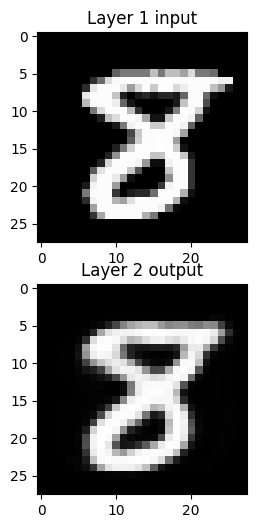

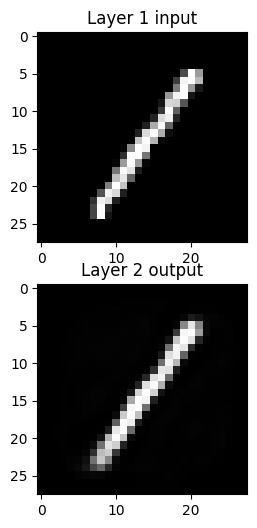

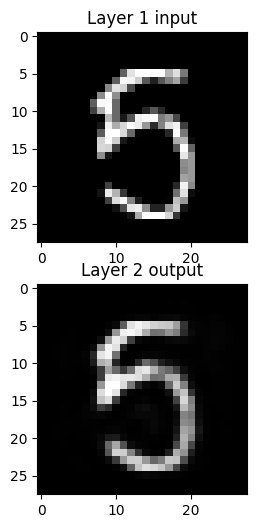

In [88]:
for i in [0, 300, 3000]:
    specific_input = val_dataset[i][0]
    plot_encoding_decoding_path(fc_autoencoder4, specific_input, input_shape=(1, -1))